In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from __future__ import absolute_import

In [2]:
from extract_data import extract_data
from finbeat_calc import finbeat_calc
from store_data import store_data
from read_data import read_data
from make_subset import make_subset
from plot_accel import plot_accel
from plot_track import plot_track
from check_plots import check_plots
from plot_analysis import plot_analysis
from sin_corr import sin_corr

# Read stored data
tracklist, finbeats, finbeat_byP, finbeat_byT = read_data('data.pickle')

In [3]:
bass_subset = make_subset(group_by1='species', identifier1='Bass', tracklist=tracklist)
bass_burst_subset = make_subset(group_by1 = 'species', identifier1='Bass', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='B')
bass_steady_subset = make_subset(group_by1 = 'species', identifier1='Bass', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='S')
bass_linacc_subset = make_subset(group_by1 = 'species', identifier1='Bass', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='A')

trout_subset = make_subset(group_by1 = 'species', identifier1 ='BTrout', tracklist=tracklist)
trout_burst_subset = make_subset(group_by1 = 'species', identifier1='BTrout', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='B')
trout_steady_subset = make_subset(group_by1 = 'species', identifier1='BTrout', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='S')
trout_linacc_subset = make_subset(group_by1 = 'species', identifier1='BTrout', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='A')

In [15]:
corr_w_sin = sin_corr(tracklist.keys(), tracklist, finbeat_byT)

C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:5041: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


In [58]:
import peakutils
import scipy
from scipy.optimize import leastsq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def plot_fit_sine(tracklist_subset, tracklist, sin_corr_df):
    
    for trial in tracklist_subset:
        data = tracklist[trial]['data']['pt2y_smth'] 
        behavior = tracklist[trial]['behavior']
        init_speed = tracklist[trial]['start_spd_BLs']
        base = peakutils.baseline(data, 3)  # Find bkgrd trend
        data = data - base
        time = data.index.values

        amp = sin_corr_df['Est.Amplitude'][trial]
        freq= sin_corr_df['Est.Freq'][trial]
        phase= sin_corr_df['Est.Phase'][trial]
        offset = sin_corr_df['Est.Offset'][trial]
        cor_coeff = str(np.round(sin_corr_df['Pearsons'][trial], 2))
        pvalue = str(np.round(sin_corr_df['Pvalue'][trial], 3))
        annotation = str('r = ' + cor_coeff + '\np = ' + pvalue)
        
        data_fit = amp * np.sin(2 * np.pi * freq * time + phase) + offset
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        fig.suptitle(trial +' '+ behavior + ' ' + str(init_speed)+'BL/s')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Position (cm)')
        ax.plot(time, data, label = 'Data')
        ax.plot(time, data_fit, label = "Sine Wave Fit")
        ax.text(0.02, 0.98,annotation, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
        ax.legend()
        plt.show()

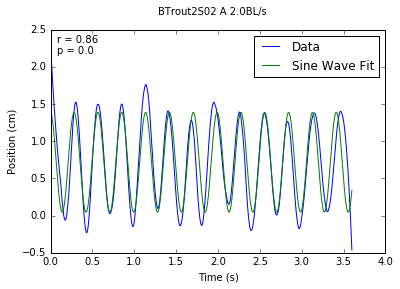

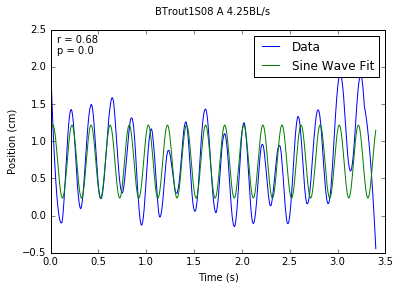

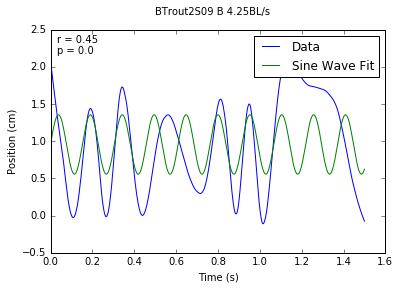

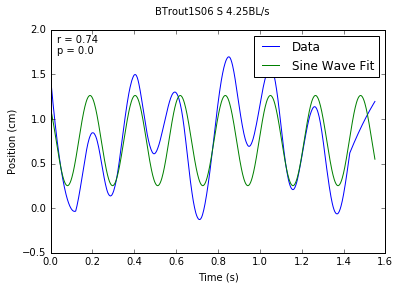

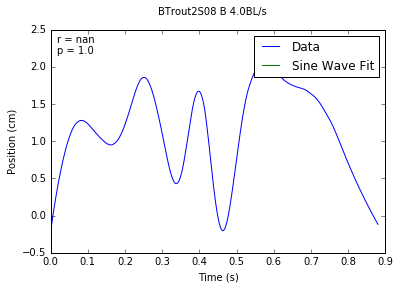

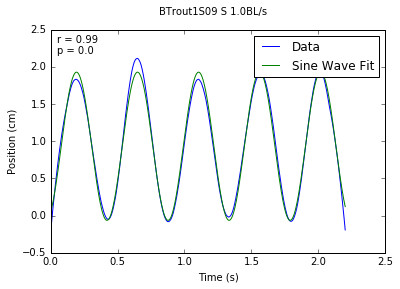

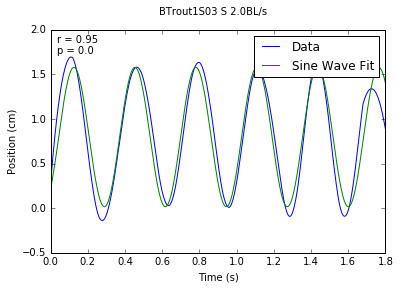

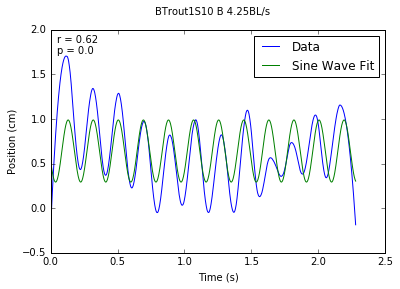

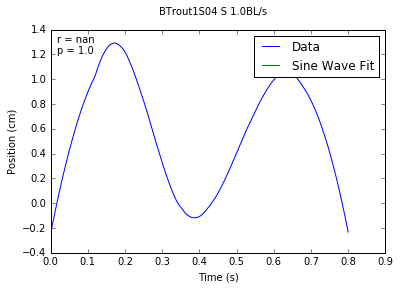

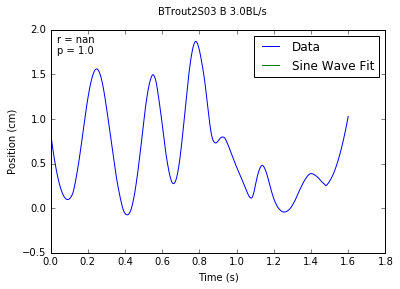

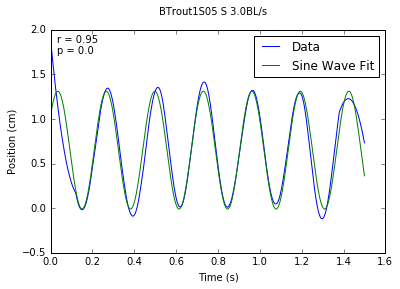

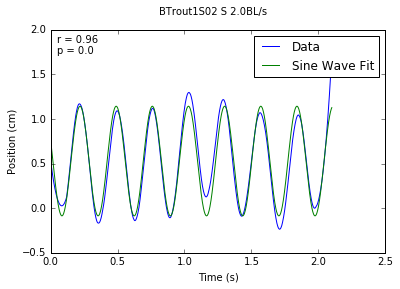

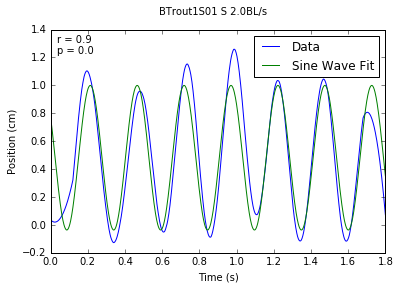

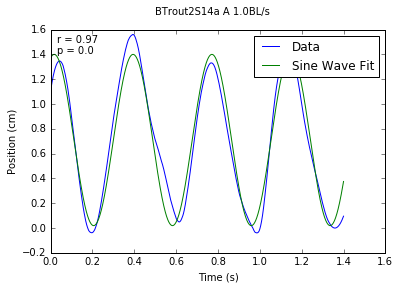

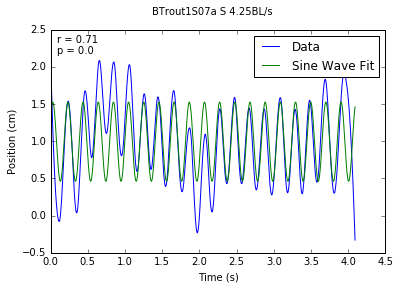

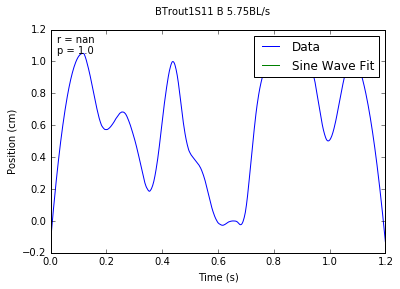

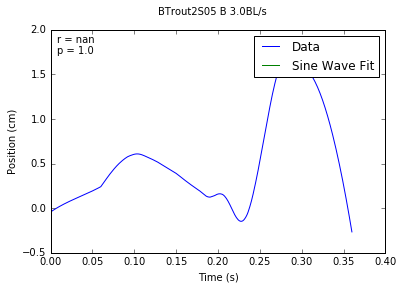

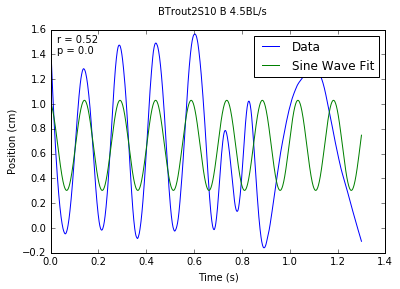

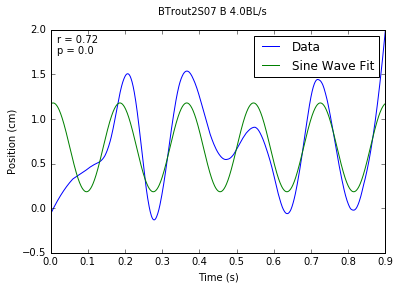

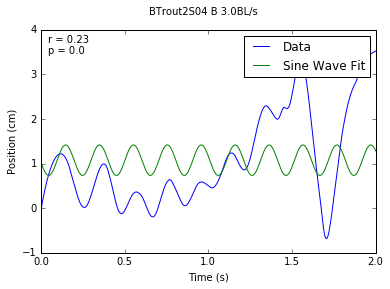

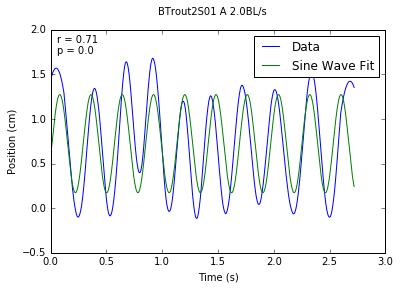

In [60]:
plot_fit_sine(trout_subset, tracklist, corr_w_sin)

In [ ]:
import matplotlib.pyplot as plt
import pywt 
from scipy import signal

testdata = tracklist['Bass1S09']['data']['pt2y_smth']
time = tracklist['Bass1S09']['data'].index.values
framerate = float(tracklist['Bass1S09']['FPS'])
scales = np.arange(2,20,1)


wavelet_choice = pywt.Wavelet('bior3.1')
print(wavelet_choice)
for i in np.arange(2,20,1):
    freq = pywt.scale2frequency(wavelet_choice, i)
    print(': scale=',i, ' freq=', freq)

In [ ]:
for name in pywt.wavelist(kind='discrete'):
    x = time
    data = testdata
    wavelet = name
    level = 1
    order = 'freq'
    interpolation = 'nearest'
    cmap = plt.cm.cool

    wp = pywt.WaveletPacket(data, wavelet, 'symmetric', maxlevel = level)
    nodes = wp.get_level(level, order = order)
    labels = [n.path for n in nodes]
    values = np.array([n.data for n in nodes], 'd')
    values = abs(values)
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, bottom=.03, left=.07, right=.97, top=.92)
    ax = fig.add_subplot(2, 1, 1)
    ax.set_title("Data")
    ax.plot(x, data, 'b')
    ax.set_xlim(0, x[-1])

    ax = fig.add_subplot(2, 1, 2)
    ax.set_title("Wavelet packet coefficients at level %d" % level)
    ax.imshow(values, interpolation=interpolation, cmap=cmap, aspect="auto",
              origin="lower", extent=[0, 1, 0, len(values)])
    ax.set_yticks(np.arange(0.5, len(labels) + 0.5), labels)

    # Show spectrogram and wavelet packet coefficients
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(211)
    ax2.specgram(data, NFFT=64, noverlap=32, Fs=2, cmap=cmap,
                 interpolation='bilinear')
    ax2.set_title("Spectrogram of signal")
    ax3 = fig2.add_subplot(212)
    ax3.imshow(values, origin='upper', extent=[-1, 1, -1, 1],
               interpolation='nearest')
    ax3.set_title("Wavelet packet coefficients")


    plt.show()



In [ ]:

import numpy as np
import matplotlib.pyplot as plt

import pywt


x = np.linspace(0, 1, num=512)
data = np.sin(250 * np.pi * x**2)

wavelet = 'db2'
level = 4
order = "freq"  # other option is "normal"
interpolation = 'nearest'
cmap = plt.cm.cool

# Construct wavelet packet
wp = pywt.WaveletPacket(data, wavelet, 'symmetric', maxlevel=level)
nodes = wp.get_level(level, order=order)
labels = [n.path for n in nodes]
values = np.array([n.data for n in nodes], 'd')
values = abs(values)

# Show signal and wavelet packet coefficients
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, bottom=.03, left=.07, right=.97, top=.92)
ax = fig.add_subplot(2, 1, 1)
ax.set_title("linchirp signal")
ax.plot(x, data, 'b')
ax.set_xlim(0, x[-1])

ax = fig.add_subplot(2, 1, 2)
ax.set_title("Wavelet packet coefficients at level %d" % level)
ax.imshow(values, interpolation=interpolation, cmap=cmap, aspect="auto",
          origin="lower", extent=[0, 1, 0, len(values)])
ax.set_yticks(np.arange(0.5, len(labels) + 0.5), labels)

# Show spectrogram and wavelet packet coefficients
fig2 = plt.figure()
ax2 = fig2.add_subplot(211)
ax2.specgram(data, NFFT=64, noverlap=32, Fs=2, cmap=cmap,
             interpolation='bilinear')
ax2.set_title("Spectrogram of signal")
ax3 = fig2.add_subplot(212)
ax3.imshow(values, origin='upper', extent=[-1, 1, -1, 1],
           interpolation='nearest')
ax3.set_title("Wavelet packet coefficients")


plt.show()